# DBLP

## 导入库

In [3]:
import codecs
import numpy as np
import pandas
import matplotlib
from xml.sax import handler, make_parser

## 数据预处理

In [2]:
#将dblp.xml转化为author.txt
paper_tag = (
    'article',
    'inproceedings',
    'proceedings',
    'book',
    'incollection',
    'phdthesis',
    'mastersthesis',
    'www'
)
#以'attention'和'transformer'为关键词，作为筛选的条件
keywords = ('attention', 'transformer')
specific_year = 2017
split_str = ' ||| '

class mHandler(handler.ContentHandler):
    def __init__(self,result):
        self.result = result
        self.flag_author = False
        self.flag_title = False
        self.flag_year = False
        self.work_info = {}

    def startElement(self, name, attrs):
        if name == 'year':
            self.flag_year = True
        if name == 'title':
            self.flag_title = True
        if name == 'author':
            self.flag_author = True

    def endElement(self, name):
        if name == 'year':
            self.flag_year = False
        if name == 'title':
            self.flag_title = False
        if name == 'author':
            self.flag_author = False

        if name in paper_tag:
            if self.work_info.get('year', 0) >= specific_year and \
                    (keywords[0] in self.work_info.get('title', '') or \
                    keywords[1] in self.work_info.get('title', '')):
                self.result.write(str(self.work_info['year'])+split_str)
                self.result.write(str(self.work_info['title'])+split_str)
                authors = self.work_info.get('author', tuple())
                for author in authors:
                    if len(author)>3 and author[-4] == '0':
                        author = author[:-5]
                    self.result.write(author+split_str)
                self.result.write('\r\n')

            self.work_info = {}
            self.flag_write = False
            self.flag_title = False
            self.flag_year = False

    def characters(self, content):
        if self.flag_year:
            self.work_info['year'] = int(content)
        if self.flag_title:
            self.work_info['title'] = str.lower(content)
        if self.flag_author:
            self.work_info['author'] = self.work_info.get('author', tuple()) + (str.lower(content),)


def parserDblpXml(source,result):
    handler = mHandler(result)
    parser = make_parser()
    parser.setContentHandler(handler)
    parser.parse(source)

In [4]:
xml_file_name = r'D:\data_mining\dblp\dataset\dblp.xml'
source = codecs.open(xml_file_name, 'r', 'utf-8')
result = codecs.open('./author.txt', 'w', 'utf-8')
parserDblpXml(source,result)
result.close()
source.close()

In [5]:
# 将author进行编码
split_str = ' ||| '
source = codecs.open('./author.txt', 'r', 'utf-8')
result = codecs.open('./author_encoded.txt', 'w', 'utf-8')
index = codecs.open('./author_index.txt', 'w', 'utf-8')
index_dict = {}
name_id = 0

for line in source:
    words = line.split(split_str)
    length = len(words)
    result.write(words[0] + split_str + words[1] + split_str)
    for i in range(2, length-1):
        name = words[i]
        if not name in index_dict.keys():
            index_dict[name] = [name_id, 1]
            name_id += 1
        else:
            index_dict[name][1] += 1
        result.write(str(index_dict[name][0]) + split_str)
    result.write('\r\n')

for name in index_dict.keys():
    index.write(str(index_dict[name][0]) + split_str \
        + name + split_str \
        + str(index_dict[name][1]) + u'\r\n')

source.close()
result.close()
index.close()

## 关联规则生成

In [ ]:
import pandas as pd
import time
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules

# 关联规则的库在fpgrowth里面

split_str = ' ||| '
min_sup = 5
min_con = 0.5
alpha = 1
beta = 10
def loadData():
    dataset = {i:[] for i in range(2017, 2025)}
    with open('./author_encoded.txt', 'r') as encode:
        for line in encode:
            words = line.split(split_str)
            length = len(words) - 1
            dataLine = [int(words[i]) for i in range(2, length)]
            dataset[int(words[0])].append(dataLine)
    return dataset

def readAuthorIndex():
    author_dict = {}
    with open('./author_index.txt', 'r') as authors_index:
        for name in authors_index:
            name = name.strip().split(split_str)
            if len(name) != 3: continue
            author_dict[int(name[0])] = [name[1], name[2]]
    return author_dict

In [13]:
print('loading the dataset...')
dataset = loadData()
author_dict = readAuthorIndex()

print('change the format to one-hot...')
df = {}
te_len = {}
co_authors = {}
teams = {}
for year in range(2017, 2025):
    data = dataset[year]
    te = TransactionEncoder()
    te_ary = te.fit(data).transform(data)
    df[year] = pd.DataFrame(te_ary, columns=te.columns_)
    te_len[year] = te_ary.shape[0]

print('get co-authors & teams...')
df_co_authors = pd.DataFrame(columns=['year', 'author', 'papers', 'active'])
df_teams = pd.DataFrame(columns=['year', 'author', 'papers', 'active'])

for year in range(2017, 2025):
    # get frequent itemsets
    frequent_itemsets = fpgrowth(df[year], min_support = min_sup/te_len[year], use_colnames=True)
    # get rules
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_con)

    co_authors = frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x)) == 2]
    teams = frequent_itemsets[frequent_itemsets.itemsets.apply(lambda x: len(x)) > 2]
    co_authors_set = set([tuple(fs) for fs in co_authors['itemsets']])
    teams_set = set([tuple(fs) for fs in teams['itemsets']])

    rules_set = set([
        (tuple(fs[0]), tuple(fs[1])) for fs in 
            zip(rules['antecedents'].tolist(), rules['consequents'].tolist())
    ])

    # remove not confident relationships
    for rel in co_authors_set:
        stay = True
        for i in range(2):
            ok = False
            for rule in rules_set:
                if rel[0:1] == rule[0] and rel[1:2] == rule[1]:
                    ok = True
                    break
            if not ok:
                stay = False
                break
        if not stay:
            co_authors = co_authors[co_authors.itemsets.apply(lambda x: tuple(x)) != rel]
    for rel in teams_set:
        stay = True
        for i in range(len(rel)):
            ok = False
            for rule in rules_set:
                if rel[:i] + rel[i+1:] == rule[0] and (rel[i],) == rule[1]:
                    ok = True
                    break
            if not ok:
                stay = False
                break
        if not stay:
            teams = teams[teams.itemsets.apply(lambda x: tuple(x)) != rel]

    # write df
    for encode_lists in co_authors['itemsets']:
        authors = []
        active = 0.0
        # get author name and active/group_papers
        for encode in encode_lists:
            authors.append(author_dict[encode][0])
            active += 1/int(author_dict[encode][1])
        active += alpha + beta / len(authors)
        authors = tuple(authors)
        # get group_papers
        for index, rows in co_authors.iterrows():
            if encode_lists == rows['itemsets']:
                papers = int(float(rows['support']) * te_len[year])
                active *= papers
                break
        df_co_authors.loc[len(df_co_authors)] = [year, authors, papers, active]
    for encode_lists in teams['itemsets']:
        authors = []
        active = 0.0
        # get author name and active/group_papers
        for encode in encode_lists:
            authors.append(author_dict[encode][0])
            active += 1/int(author_dict[encode][1])
        active += alpha + beta / len(authors)
        authors = tuple(authors)
        # get group_papers
        for index, rows in teams.iterrows():
            if encode_lists == rows['itemsets']:
                papers = int(float(rows['support']) * te_len[year])
                active *= papers
                break
        df_teams.loc[len(df_teams)] = [year, authors, papers, active]

print("Writing result into csv...")
df_co_authors.to_csv(
    r'D:\data_mining\dblp\result\result_co_authors_' + str(min_sup) + '_' + str(min_con) + '.csv',
    index=False
)
df_teams.to_csv(
     r'D:\data_mining\dblp\result\result_teams_' + str(min_sup) + '_' + str(min_con) + '.csv',
    index=False
)

loading the dataset...
change the format to one-hot...
get co-authors & teams...
Writing result into csv...


## 可视化分析

In [15]:
co_authors = pd.read_csv(r'D:\data_mining\dblp_2\result\result_co_authors_5_0.5.csv')
teams = pd.read_csv(r'D:\data_mining\dblp_2\result\result_teams_5_0.5.csv')
co_authors.head(10)

,year,authors,papers,active
0,2017,"('hanwang zhang', 'tat-seng chua')",5,30.513158
1,2017,"('zhou zhao', 'yueting zhuang')",6,36.392857
2,2017,"('kang liu', 'jun zhao')",5,30.401515
3,2017,"('haewoon kwak', 'jisun an')",6,37.500000
4,2017,"('edison marrese-taylor', 'yutaka matsuo')",6,36.878788
5,2017,"('takaaki hori', 'shinji watanabe')",5,30.250000
6,2017,"('lianli gao', 'heng tao shen')",5,30.247059
7,2017,"('xiaogang wang', 'wanli ouyang')",6,36.266667
8,2017,"('guanbin li', 'liang lin')",5,30.261905
9,2018,"('yi liu', 'yujiu yang')",6,36.390374


In [16]:
teams.head(10)

,year,authors,papers,active
0,2018,"('chengqi zhang', 'guodong long', 'jing jiang')",6,26.633333
1,2018,"('chengqi zhang', 'tianyi zhou', 'jing jiang')",6,26.819608
2,2018,"('chengqi zhang', 'tianyi zhou', 'guodong long')",6,26.852941
3,2018,"('tianyi zhou', 'guodong long', 'jing jiang')",6,26.652941
4,2018,"('chengqi zhang', 'tianyi zhou', 'guodong long...",6,21.986275
5,2018,"('chengqi zhang', 'tao shen', 'tianyi zhou')",6,26.936275
6,2018,"('tao shen', 'tianyi zhou', 'jing jiang')",6,26.736275
7,2018,"('tao shen', 'tianyi zhou', 'guodong long')",6,26.769608
8,2018,"('chengqi zhang', 'tao shen', 'jing jiang')",6,26.716667
9,2018,"('chengqi zhang', 'tao shen', 'guodong long')",6,26.750000


In [6]:
co_authors_group_size = co_authors.groupby('year').size()
co_authors_group_size

year
2017      9
2018     31
2019     91
2020    113
2021    122
2022    370
2023    429
dtype: int64

In [7]:
import matplotlib.pyplot as plt 
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体为黑体  
plt.rcParams['axes.unicode_minus'] = False

In [10]:
co_authors_group_size_df = co_authors_group_size.reset_index(name='count') 
teams_group_size_df = teams_group_size.reset_index(name='count') 
new_data = {'year':2017,'count':0}
teams_group_size_df.loc[-1] = new_data
teams_group_size_df = teams_group_size_df.sort_index() 
teams_group_size_df = teams_group_size_df.reset_index(drop=True)
teams_group_size_df

,year,count
0,2017,0
1,2018,16
2,2019,55
3,2020,64
4,2021,43
5,2022,365
6,2023,1125


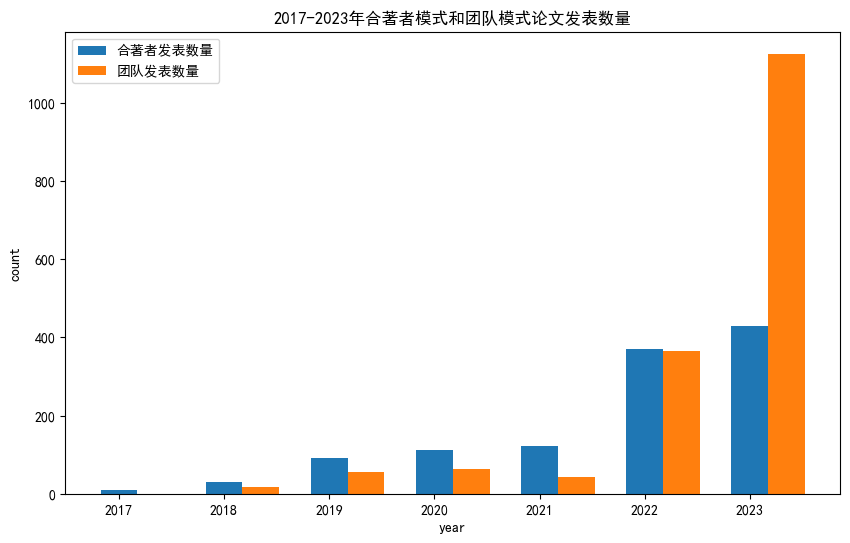

In [13]:
plt.figure(figsize=(10, 6)) 
bar_width = 0.35
plt.bar(co_authors_group_size_df['year'], co_authors_group_size_df['count'], bar_width, label='合著者发表数量') 
plt.bar(teams_group_size_df['year']+bar_width, teams_group_size_df['count'], bar_width, label='团队发表数量')
# 添加图例  
plt.legend()  
  
# 添加标题和轴标签  
plt.title('2017-2023年合著者模式和团队模式论文发表数量')  
plt.xlabel('year')  
plt.ylabel('count')  
  

# 设置x轴的刻度位置，以便它们与柱形的中心对齐  
#plt.xticks(ind + bar_width / 2, co_authors_group_size_df['year']) 
  
# 显示图形  
plt.show()

# 作者活跃程度

In [74]:
def sort_group(group):  
    return group.sort_values(by='papers') 
co_authors_sorted = co_authors.groupby('year', as_index=False).apply(sort_group) 
teams_sorted = teams.groupby('year', as_index=False).apply(sort_group) 

In [72]:
co_authors_sorted.groupby('year').head(5)

year                                     authors  papers     active
0 0     2017          ('hanwang zhang', 'tat-seng chua')       5  30.513158
  2     2017                    ('kang liu', 'jun zhao')       5  30.401515
  5     2017         ('takaaki hori', 'shinji watanabe')       5  30.250000
  6     2017             ('lianli gao', 'heng tao shen')       5  30.247059
  8     2017                 ('guanbin li', 'liang lin')       5  30.261905
1 24    2018              ('tianlang chen', 'jiebo luo')       5  30.506567
  36    2018                     ('shiyu zhou', 'bo xu')       5  30.792411
  35    2018                 ('shiyu zhou', 'shuang xu')       5  31.098901
  32    2018                ('jinsong su', 'deyi xiong')       5  30.400641
  31    2018             ('rongwu zhu', 'marco liserre')       5  30.586124
2 74    2019        ('marco faifer', 'roberto ottoboni')       5  30.625000
  67    2019              ('jaewoo kang', 'raehyun kim')       5  30.833333
  96    2019          ('xiao-hu zhou', 'zeng-guang hou')       5  30.647773
  95    2019           ('zhen-liang ni', 'xiao-hu zhou')       5  30.839161
  94    2019            ('gui-bin bian', 'xiao-hu zhou')       5  30.634615
3 187   2020               ('simon doclo', 'ali aroudi')       5  30.871212
  164   2020   ('ankit singh rawat', 'sashank j. reddi')       5  30.884615
  198   2020    ('michael l. seltzer', 'yongqiang wang')       5  30.833333
  166   2020         ('chulhee yun', 'sashank j. reddi')       5  31.214286
  167   2020     ('srinadh bhojanapalli', 'chulhee yun')       5  30.992063
4 244   2021                          ('ois br', 'fran')       6  36.532127
  306   2021                    ('yifan zhao', 'jia li')       6  36.752351
  364   2021                    ('hongfei lin', 'bo xu')       6  36.236607
  303   2021            ('n fernandez astudillo', 'ram')       6  37.250000
  302   2021  ('n fernandez astudillo', 'tahira naseem')       6  37.416667
5 366   2022                ('yanzhi wang', 'geng yuan')       5  30.502451
  564   2022                    ('gr', 'goire lefebvre')       5  31.111111
  566   2022                  ('yang nan', 'guang yang')       5  30.816327
  567   2022  ('farnoosh naderkhani', 'arash mohammadi')       5  30.931677
  568   2022              ('jiahao huang', 'huanjun wu')       5  31.416667
6 736   2023              ('shaohui mei', 'mingyang ma')       5  30.902778
  1006  2023          ('heinrich dinkel', 'zhiyong yan')       5  32.000000
  1005  2023        ('heinrich dinkel', 'yongqing wang')       5  31.833333
  1004  2023             ('yujun wang', 'yongqing wang')       5  31.111111
  1003  2023            ('junbo zhang', 'yongqing wang')       5  31.127451

## 结论
1. 在活跃的合著者中，一些作者反复出现，推测这些作者是导师的身份，而只是偶尔出现的可以认为是学生。
2. 在发表论文数量方面，2018年共同作者论文数量激增，推测受2017年谷歌发表的论文《Attention is All You Need》的影响，Transformer架构大火，引发了相关领域发文的高潮。在这之后，2023年论文发表也产生了高潮，估计与ChatGPT的爆火也有关系。可见Transformer模型的影响力。